# Perspectives on Utilization of Measurements in Quantum Algorithms
<center>
<div style="font-family: Georgia, serif; margin: 1em 0;">
  <ul style="list-style-type: none; padding: 0;">
    <li style="margin: 0.2em 0; font-size: 1.2em;">Valter Uotila, Ilmo Salmenperä,</li>
    <li style="margin: 0.2em 0; font-size: 1.2em;">Leo Becker, Arianne Meijer-van de Griend,</li>
      <li style="margin: 0.2em 0; font-size: 1.2em;">Aakash Ravindra Shinde, Jukka K. Nurminen</li>
  </ul>
</div>
</center>

<center>
<img src="https://upload.wikimedia.org/wikipedia/en/thumb/8/84/University_of_Helsinki.svg/1280px-University_of_Helsinki.svg.png" alt="HY-logo" width="200" height="200">
</center>

## Outline of this presentation

1. Introduction and motivation
2. Categories for measurement operations with code examples
   1. Static quantum circuits (Code demo: Recovering a density matrix)
   2. Dynamic quantum circuits (Code demo: Toffoli gate teleportation)
   3. Measurements as solutions to challenges in NISQ devices
3. Conclusion

## Motivation

1. There are no previous works which would survey the role of measurements in practical quantum algorithms and emphasize their key role in the algorithms
2. Measurements are not necessarily the key contribution in many papers, although many algorithms utilize clever measurement schemes. Building a ''measurement toolbox'' might help us choose the best measurement scheme for algorithms or try something new.

## Scope
This paper contains only a subset of measurement operation use cases. For example, we left out:
1. Error-correcting codes
2. Measurement-based quantum computing
3. Hidden parameter extraction

## Introduction


| **Measurement theory**     | **Properties**                                                                                                                                         | **Quantum states** | **Properties**                                                                                      |
|---------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------|------------------------------------------------------------------------------------------------------|
| **PVM measurements**      | Idempotent: $P_i^2 = P_i$  <br> Orthogonality: $P_i P_j = \delta_{ij}P_i$ <br> Completeness: $\sum_i P_i = I$                                            | **Pure states**    | Idempotent: $\rho^2 = \rho$ <br> Projection onto 1D subspace <br> Normalization: $\text{Tr}(\rho) = 1$ |
| **POVM measurements**     | Positive operators $E_i \geq 0$ <br> Completeness: $\sum_i E_i = I$ <br> Not necessarily orthogonal <br> Generalization of PVMs                          | **Mixed states**   | Positive operators $\rho \geq 0$ <br> Normalization: $\text{Tr}(\rho) = 1$ <br> Not necessarily pure <br> Generalization of pure states |

## Category 1: Static quantum circuits

Measure the whole state so that the measurement outcomes do not affect the current circuit execution.

1. Fundamental quantum algorithms
2. Variational quantum computing
   1. Quantum optimization: optimiziation problems are measurements
   2. Quantum machine learning: global observables lead to barren plateaus
   3. Quantum machine learning: measurements are a source of non-linearity
3. Classical machine learning for measurement optimization

The difference in how we measure, comparing the fundamental quantum algorithms and variational quantum algorithms, is interesting.

## Demonstration on Informationally Complete Positive-Valued Operator Measures (IC-POVM)

Consider the following set of POVMs
\begin{align}
    E_{+z} &= p_z |0\rangle\langle0|, &\quad E_{-z} &= p_z |1\rangle\langle1|, \\
    E_{\pm x} &= p_x | \pm \rangle \langle \pm |, &\quad E_{\pm y} &= p_y | \pm i \rangle \langle \pm i |,
\end{align}
where $p_{z}, p_{x}, p_{y} \in [0, 1]$ so that $p_{z} + p_{x} + p_{y} = 1$.

The reconstruction of the state is done with so-called dual operators, which are given by
\begin{align}
    D_{\pm \alpha} = \frac{I \pm \sigma_{\alpha}/p_{\alpha}}{2},
\end{align}
where $\sigma_{\alpha}$ is the corresponding Pauli matrix, $p_{\alpha}$ is the probability and $\alpha \in \left\{x, y, z \right\}$.

With the dual operators, the reconstructed state $\rho$ has the following form
\begin{align}
    \rho = \sum_{k \in I} \mathrm{Tr}(\rho E_k) D_k.
\end{align}

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]

from qiskit_aer import Aer
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

backend = Aer.get_backend('statevector_simulator') 
#backend = FakeManilaV2()

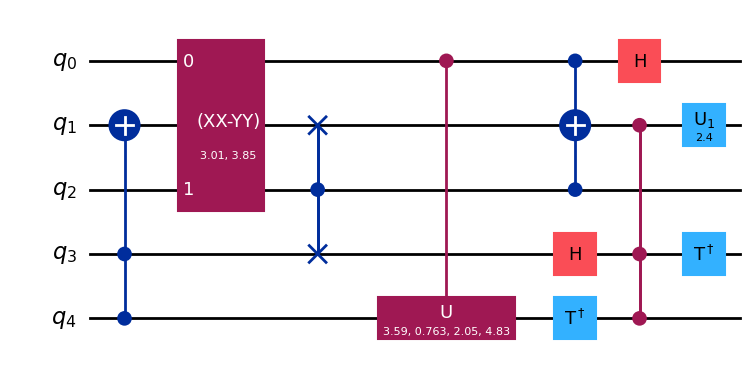

In [2]:
from qiskit.circuit.random import random_circuit

n_qubits = 5
circuit = random_circuit(n_qubits, 5, measure=False)
fig = circuit.draw(output='mpl')
plt.show()

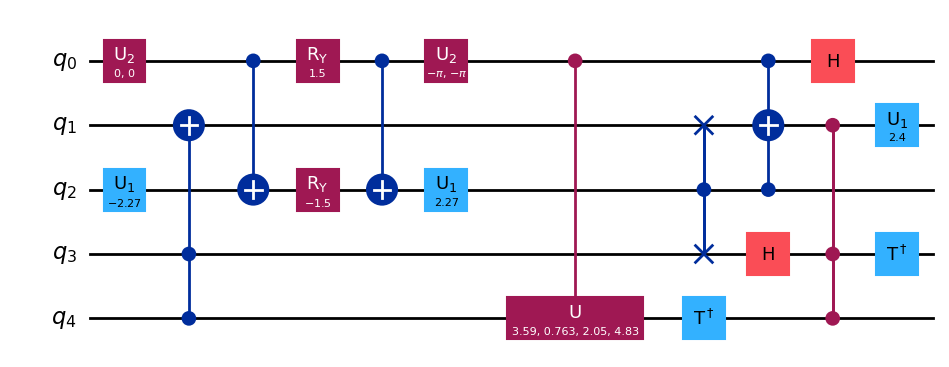

In [3]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=1)
transpiled_circuit = pass_manager.run(circuit)
fig = transpiled_circuit.draw(output='mpl')
plt.show()

In [4]:
from povm_toolbox.sampler import POVMSampler 
from povm_toolbox.library import ClassicalShadows
from povm_toolbox.post_processor import POVMPostProcessor

from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
povm_sampler = POVMSampler(sampler=sampler)
measurement = ClassicalShadows(num_qubits=n_qubits, seed=0)

job = povm_sampler.run([circuit], shots=2000, povm=measurement, pass_manager=pass_manager)
pub_result = job.result()[0]
counts = pub_result.get_counts()

observable = SparsePauliOp.from_list([("ZIIII", 1), ("IZIII", 1), ("IIZII", 1), ("IIIZI", 1), ("IIIIZ", 1)])

post_processor = POVMPostProcessor(pub_result)
exp_value, std= post_processor.get_expectation_value(observable)
print("Noisy expectation value: ", exp_value)

Noisy expectation value:  -2.8214999999999995


In [5]:
from qiskit.quantum_info import Statevector, SparsePauliOp

statevector = Statevector.from_instruction(circuit)

# Compute the exact expectation value
expectation_value = statevector.expectation_value(observable)
print("Expectation value:", expectation_value.real)

Expectation value: -2.875016384761908


In [6]:
probabilities = {}
for res, count in counts.items():
   c = tuple((int(r) for r in res))
   probabilities[c] = count / shots

NameError: name 'shots' is not defined

In [ ]:
from qiskit.quantum_info import Operator, DensityMatrix
from functools import reduce
import operator

density_matrix = None

for state, prob in probabilities.items():
    duals = [post_processor.dual[(qubit_id,)].operators[povm_id] for qubit_id, povm_id in enumerate(reversed(state))]
    
    # Convert to Operators
    dual_operators = [Operator(dual) for dual in duals]
    
    # Compute tensor product using reduce
    tensor_product_op = reduce(lambda a, b: a.tensor(b), dual_operators)
    
    # Scale and accumulate
    if density_matrix is None:
        density_matrix = prob * tensor_product_op
    else:
        density_matrix = density_matrix + prob * tensor_product_op

density_matrix = DensityMatrix(density_matrix.data)

# Compute expectation value
expectation_value = density_matrix.expectation_value(observable)
print(f"Expectation value: {expectation_value.real}")

In [ ]:
from utils import visualize_density_matrix
    
# Use the enhanced visualization
visualize_density_matrix(density_matrix, n_qubits)

## Category 2: Dynamic quantum circuits

Dynamic quantum circuits modify the quantum state during the computation via mid-circuit measurements

In the paper, we discuss:
* State preparation using dynamic quantum circuits
* State and gate teleportation

## Toffoli gate teleportation

Gate teleportation generally:

<center>
<img src="figures/gate_teleportation.png" alt="gate_teleportation" width="800">
</center>

In [ ]:
import pennylane as qml
import numpy as np

# Get matrix for toffoli gate
def get_toffoli_matrix():
    return np.array(qml.Toffoli(wires=[0,1,2]).matrix())

X0, X1, X2 = qml.PauliX(0), qml.PauliX(1), qml.PauliX(2)
Z0, Z1, Z2 = qml.PauliZ(0), qml.PauliZ(1), qml.PauliZ(2)
I0, I1, I2 = qml.Identity(0), qml.Identity(1), qml.Identity(2)

basis = [Z0 @ I1 @ I2, 
        I0 @ Z1 @ I2,
        I0 @ I1 @ Z2,
        X0 @ I1 @ I2,
        I0 @ X1 @ I2,
        I0 @ I1 @ X2]

results = []
for b in basis:
    results.append(get_toffoli_matrix() @ b.matrix() @ get_toffoli_matrix())
    
pauli_decomposed = []

for result in results:
    pauli_decomposed.append(qml.pauli_decompose(result, wire_order=[6, 7, 8]))

for p in pauli_decomposed:
    print(p.coeffs, p.ops)

In [ ]:
from utils import controlled_circuit1, controlled_circuit2, controlled_circuit3, controlled_circuit4, controlled_circuit5

# To visualize and debug the circuits
@qml.qnode(dev)
def circuit2():
    controlled_circuit2(np.pi/2)
    return qml.sample()

qml.draw_mpl(circuit2)()

In [ ]:
dev = qml.device("default.qubit", wires=[0, 1, 2, 3, 4, 5, 6, 7, 8])
values = np.random.rand(9)

def bell_pair(source, target):
    qml.Hadamard(wires=source)
    qml.CNOT(wires=[source, target])
    
def bell_measurement(source, target):
    qml.CNOT(wires=[source, target])
    qml.Hadamard(wires=source)

@qml.qnode(dev)
def toffoli_teleportation():
    # Prepare the random input state for Toffoli gate
    
    qml.Rot(values[0], values[1], values[2], wires=0)
    qml.Rot(values[3], values[4], values[5], wires=1)
    qml.Rot(values[6], values[7], values[8], wires=2)
    
    # Prepare Bell pairs
    bell_pair(3, 6)
    bell_pair(4, 7)
    bell_pair(5, 8)
    
    #Prepare the Bell measurement
    bell_measurement(0, 3)
    bell_measurement(1, 4)
    bell_measurement(2, 5)
    
    # Perform the Toffoli gate on the output qubits
    qml.Toffoli(wires=[6, 7, 8])
    
    # Perform the Bell measurement
    m0 = qml.measure([0], reset=True)
    m1 = qml.measure([1], reset=True)
    m2 = qml.measure([2], reset=True)
    a0 = qml.measure([3], reset=True)
    a1 = qml.measure([4], reset=True)
    a2 = qml.measure([5], reset=True)
    
    glob_coeff = np.pi/2
    qml.cond(m0, controlled_circuit1)([6], coeff=2*glob_coeff)
    qml.cond(m1, controlled_circuit1)([7], coeff=2*glob_coeff)
    qml.cond(m2, controlled_circuit2)(coeff=glob_coeff)
    qml.cond(a0, controlled_circuit3)(coeff=glob_coeff)
    qml.cond(a1, controlled_circuit4)(coeff=glob_coeff)
    qml.cond(a2, controlled_circuit5)(coeff=2*glob_coeff)
    
    return qml.density_matrix(wires=[6, 7, 8])

In [ ]:
qml.draw_mpl(toffoli_teleportation)()

In [ ]:
results = toffoli_teleportation()

dev = qml.device("default.qubit", wires=[0, 1, 2])
@qml.qnode(dev)
def toffoli_teleportation2():
    qml.Rot(values[0], values[1], values[2], wires=0)
    qml.Rot(values[3], values[4], values[5], wires=1)
    qml.Rot(values[6], values[7], values[8], wires=2)
    qml.Toffoli(wires=[0, 1, 2])
    return qml.density_matrix(wires=[0, 1, 2])

#print(toffoli_teleportation2())

# Compare that the density matrix from the teleportation circuit is 
# the same as the one when the Toffoli gate is applied directly
print(np.allclose(results, toffoli_teleportation2()))

## Measurements as solutions to challenges in NISQ devices

In the paper, we discuss:

1. Quantum hardware scalability problem: Circuit cutting
2. Quantum hardware error problem: Quantum error mitigation

#### Circuit cutting
<center>
<img src="figures/circuit_cutting_1.png" alt="circuit_cutting_1" width="400">
<img src="figures/circuit_cutting_2.png" alt="circuit_cutting_2" width="400">
</center>

## Example on error mitigation connecting to the IC-POVM example

<center>
<img src="figures/TEM.png" alt="gate_teleportation" width="800">
</center>

## Conclusion and future work

In this work, we review measurement operation use cases and divide them into three categories:
1. Static quantum circuits (Code demo: Recovering a density matrix)
2. Dynamic quantum circuits (Code demo: Toffoli gate teleportation)
3. Measurements as solutions to quantum computational challenges

Concluding
1. Measuring creates challenges but also possibilities to improve the performance of your algorithms.
2. Measurement is not only a passive ''quantum return statement'' at the end

In future work, we will pay attention to measurements in our algorithms and extend the paper.

# Thank you!